In [2]:
#RL
from tensorforce import Runner
from tensorforce import Environment
from tensorforce import Agent
#keras
import tensorflow as tf
#basic
import numpy as np
import pandas as pd
#sklearn
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
#image processing
from skimage.future import graph
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import felzenszwalb
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.transform import rescale
#visialization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette("Set2")
#skmultiflow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.rules import VeryFastDecisionRulesClassifier
from skmultiflow.trees import ExtremelyFastDecisionTreeClassifier
#scikit 
from scipy.spatial import distance_matrix
#graph
import networkx as nx
#ontology
import owlready2 as owl
#language model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#other
from itertools import count

In [3]:
print(tf.__version__)

2.6.0


In [4]:
%load_ext tensorboard

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
trace=np.load("./record/trace-000000000.npz")

States=trace["states"]

Rewards=trace["reward"]

Actions=trace["actions"]

# help functions

In [7]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

In [8]:
img = rgb2gray(States[89])

# apply threshold
thresh = threshold_otsu(img)
reg = closing(img > thresh, square(3))

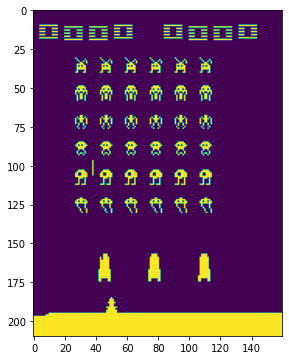

In [9]:
show_image(np.max(States[89]>0,axis=-1))

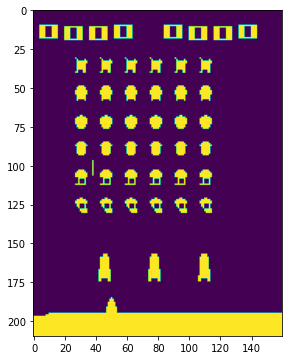

In [10]:
show_image(reg)

In [11]:
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape[0:2]
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2),
                    (0,0)
                    ),
                  mode = 'constant')

In [12]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (height, width))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [13]:
def visualize_objects(label_image,image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 5:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [14]:
def find_objects(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(3))

    # label image regions
    label_image = label(reg)
    
    return label_image

In [15]:
def find_cut_objects(image,m_h,m_w):
    label_image=find_objects(image)
    regions=regionprops(label_image)
    i=len(regions)-1
    for reg in regions:
        minr, minc, maxr, maxc = reg.bbox
        split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
        split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
        for x in range(int(np.ceil((maxr-minr)/m_h))):
            for y in range(int(np.ceil((maxc-minc)/m_w))):
                i=i+1
                label_image[reg.slice][split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]][reg.image[split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]]]=i


    regions=regionprops(label_image)
    objects=np.array([to_shape(image[reg.slice],(m_h,m_w)) for reg in regions])
    return label_image, objects, regions

In [16]:
def regions_to_graph(regions,labels,prox=60):
    #weighted?
    centroids=np.array([reg.centroid for reg in regions])
    dist=distance_matrix(centroids,centroids)
    dist=(dist<prox)*dist
    G = nx.from_numpy_matrix(dist)
    lab={x:str(labels[x]) for x in range(len(centroids))}
    nx.set_node_attributes(G, lab, "feature")
    pos_x={x:centroids[x][0] for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_x, "position_x")
    pos_y={x:centroids[x][1] for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_y, "position_y")
    return G

In [17]:
def visualize_graph(g):
    groups = set(nx.get_node_attributes(g,'feature').values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = g.nodes()
    colors = [mapping[g.nodes[n]['feature']] for n in nodes]  
    
    pos = nx.spring_layout(g)
    for n in nodes:
        pos[n][1]=-1*g.nodes[n]['position_x']
        pos[n][0]=g.nodes[n]['position_y']

    ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()

In [18]:
def graph_to_embedding(Graphs,model,iterations=2,epochs=10,keep_train=True,rebuild_vocab=False,seed=42):
    Doc_all=[]
    for i in range(len(Graphs)):
        hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[Graphs[i].nodes[node]["feature"]]+hashes[node]
        
        Doc_all=Doc_all+[Doc.copy()]
        #removing tags because of errors in training
    documents = [
            TaggedDocument(words=doc, tags=[])
            for i, doc in enumerate(Doc_all)
        ]
    
    if rebuild_vocab:
        if len(model.wv)>0:
            model.build_vocab(documents,update=True)
        else:
            model.build_vocab(documents)
        
    if keep_train:
        model.train(documents,total_examples=len(documents),epochs=epochs)
        
    #np.array([model.docvecs[str(i)] for i, _ in enumerate(Doc_all)])
    model.random.seed(seed)
    return np.array([model.infer_vector(doc) for doc in Doc_all])

# Enviroment

In [19]:
# OpenAI-Gym environment specification
environment = Environment.create(
       environment='gym', level='SpaceInvaders-v4',max_episode_timesteps=1000)


/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SpaceInvaders-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/SpaceInvaders-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [20]:
class CustomEnvironment2(Environment):

    def __init__(self, base_env):
        self.base_env=base_env
        self.image_seg=Birch(n_clusters=None,threshold=0.85)
        self.pca_obj=IncrementalPCA(n_components=30)
        self.state_param={}
        self.state_param["type"]="bool"
        self.state_param["shape"]=self.base_env.states()["shape"][0:2]
        #self.state_param["num_values"]=256
        self.example_objects={}
        
        super().__init__()

    def states(self):
        return self.state_param

    def actions(self):
        return self.base_env.actions()

    def preprocess_state(self, state):
        label_image=find_objects(state)
        return label_image>0
        
        
        
    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = self.base_env.reset()
        state=self.preprocess_state(state)
        return state

    def execute(self, actions):
        next_state, terminal, reward = self.base_env.execute(actions)
        
        next_state=self.preprocess_state(next_state)
        
        return next_state, terminal, reward

In [21]:
class CustomEnvironment(Environment):

    def __init__(self, base_env):
        self.base_env=base_env
        self.num_clusters_obj=16
        self.image_seg=Birch(n_clusters=None,threshold=128,branching_factor=100)
        self.pca_obj=IncrementalPCA(n_components=50)
        self.max_obj_width=160//10
        self.max_obj_height=210//10
        self.prox=40
        self.state_param={}
        self.state_param["type"]="float"
        self.state_param["shape"]=128
        self.state_param["min_value"]=-1
        self.state_param["max_value"]=1
        self.example_objects={}
        self.example_objects_pca={}
        self.total_timestep=0
        self.keep_train=True
        self.rebuild_vocab=True
        self.iterations=1
        #graph list 
        self.graph_list=[]
        #state list
        self.keep_state_list=False
        
        self.state_list=[]
        #semantic model
        self.bulk_learn=64
        self.dimensions=128
        self.min_count=1
        self.seed=42
        self.workers = 4
        self.epochs = 20
        self.learning_rate = 0.025
        self.window=5
        self.hs=1
        self.dm=1
        self.negative=0
        self.max_vocab_size=30000
        self.semantic_model=Doc2Vec(
            vector_size=self.dimensions,
            window=self.window,
            min_count=self.min_count,
            dm=self.dm,
            hs=self.hs,
            negative=self.negative,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            max_vocab_size=self.max_vocab_size,
            seed=self.seed
        )
        
        super().__init__()

    def states(self):
        return self.state_param

    def actions(self):
        return self.base_env.actions()

    def train_semantic(self):
        #make embedding
        graph_to_embedding(self.graph_list,self.semantic_model,iterations=self.iterations,epochs=self.epochs,keep_train=True,rebuild_vocab=True,seed=42)
        
    
    def preprocess_state(self, state, train=False, rebuild_vocab=False, train_semantic=False):
        
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        #PCA
        if train:
            self.pca_obj.partial_fit(np.vstack((X,X)))
            
        X=self.pca_obj.transform(X)
        
        #BIRCH clustering
        if train:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.num_clusters_obj-1:
                self.image_seg.set_params(n_clusters=self.num_clusters_obj-1)
                self.image_seg.partial_fit()
                
        labels=self.image_seg.predict(X)
            
        for i in range(len(labels)):
            if train:
                self.example_objects[labels[i]]=state[regions[i].slice]
                self.example_objects_pca[labels[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
        
        #make graph
        graph=regions_to_graph(regions,labels,prox=self.prox)
        
        #make embedding
        embedding=graph_to_embedding([graph],self.semantic_model,iterations=self.iterations,epochs=self.epochs,keep_train=train_semantic,rebuild_vocab=rebuild_vocab,seed=42)
        
        #clip emmbeding
        embedding=np.clip(embedding,self.state_param["min_value"], self.state_param["max_value"])[0]
        #smaller image
        label_image=np.max(np.dstack((label_image[0::2,0::2],label_image[1::2,1::2])),axis=-1)
        return label_image.astype("int8"),regions,labels,graph,embedding
        
        
        
    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = self.base_env.reset()
        _,_,_,graph,state = self.preprocess_state(state, train=True, rebuild_vocab=True, train_semantic=True)
        return state

    def execute(self, actions):
        next_state, terminal, reward = self.base_env.execute(actions)
        
        if self.keep_state_list:
            self.state_list.append(next_state)
        
        self.total_timestep+=1
        if self.total_timestep<500:
            self.keep_train=True
        else:
            self.keep_train=False
        
        if self.total_timestep%self.bulk_learn==0:
            self.train_semantic()
            self.graph_list=[]
            #print(self.total_timestep)
        
        _,_,_,graph,next_state=self.preprocess_state(next_state,self.keep_train)
        self.graph_list.append(graph)
        
        return next_state, terminal, reward

In [22]:
class CustomEnvironment3(Environment):

    def __init__(self, base_env):
        self.base_env=base_env
        self.image_seg=Birch(n_clusters=None,threshold=128,branching_factor=100)
        self.pca_obj=IncrementalPCA(n_components=60)
        self.max_obj_width=160//10
        self.max_obj_height=210//10
        self.state_param={}
        self.state_param["type"]="int"
        self.state_param["shape"]=(self.base_env.states()["shape"][0]//2,self.base_env.states()["shape"][1]//2)
        self.state_param["num_values"]=32
        self.example_objects={}
        self.example_objects_pca={}
        self.iteration=0
        self.keep_train=True
        
        super().__init__()

    def states(self):
        return self.state_param

    def actions(self):
        return self.base_env.actions()

    def preprocess_state(self, state, train=True):
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if train:
            self.pca_obj.partial_fit(np.vstack((X,X)))
            
        X=self.pca_obj.transform(X)
        
        if train:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.state_param["num_values"]-1:
                self.image_seg.set_params(n_clusters=self.state_param["num_values"]-1)
                self.image_seg.partial_fit()
                self.image_seg.labels_=self.image_seg.predict(X)
        else:
            self.image_seg.labels_=self.image_seg.predict(X)
            
        
        for i in range(len(self.image_seg.labels_)):
            if train:
                self.example_objects[self.image_seg.labels_[i]]=state[regions[i].slice]
                self.example_objects_pca[self.image_seg.labels_[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=self.image_seg.labels_[i]+1
        
        label_image=np.max(np.dstack((label_image[0::2,0::2],label_image[1::2,1::2])),axis=-1)
        return label_image.astype("int8"),regions,self.image_seg.labels_
        
        
        
    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = self.base_env.reset()
        state,_,_ = self.preprocess_state(state)
        return state

    def execute(self, actions):
        next_state, terminal, reward = self.base_env.execute(actions)
        
        if self.iteration<500:
            self.iteration+=1
        else:
            self.keep_train=False
        
        next_state,_,_=self.preprocess_state(next_state,self.keep_train)
        
        return next_state, terminal, reward

In [23]:
custom=CustomEnvironment(environment)

# Agent

In [24]:
# PPO agent specification
agent = dict(
    agent='dqn',
    # Automatically configured network
    network='auto',
    # Parameters
    memory= 1700 ,
    batch_size = 16 , 
    # Reward estimation
    discount=0.95, predict_terminal_values=False,
    reward_processing=None,
    # Baseline network and optimizer
    #baseline=dict(type='auto', size=32, depth=1),
    #baseline_optimizer=dict(optimizer='adam', learning_rate=1e-3, multi_step=10),
    # Regularization
    l2_regularization=0.0, 
    entropy_regularization=0.0,
    # Preprocessing
    #state_preprocessing='linear_normalization',
    # Exploration
    exploration=0.1,
    variable_noise=0.0,
    # Default additional config values
    config=None,
    # Save agent every 10 updates and keep the 5 most recent checkpoints
    saver=dict(directory='model', frequency=10, max_checkpoints=5),
    # Log all available Tensorboard summaries
    summarizer=dict(directory='summaries', summaries='all'),
    # Do record agent-environment interaction trace
    #recorder=dict(directory='record')
)

# Initialize the runner
runner = Runner(agent=agent, environment=custom, max_episode_timesteps=1000)

# Train for 200 episodes
runner.run(num_episodes=10)
runner.close()

Episodes:   0%|          | 0/10 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

In [36]:
%time _,_,_,_=custom.preprocess_state(States[0],train=True)

CPU times: user 1.98 s, sys: 1.89 s, total: 3.87 s
Wall time: 1.68 s


In [26]:
%time _,_,_,_,_=custom.preprocess_state(States[0],train=False)

CPU times: user 35.4 ms, sys: 62.7 ms, total: 98.1 ms
Wall time: 27.8 ms


# Optimizing

In [28]:
state=States[89]

In [29]:
train=False

In [30]:
%time label_image, objects, regions=find_cut_objects(state,custom.max_obj_height,custom.max_obj_width)

CPU times: user 16.3 ms, sys: 684 µs, total: 17 ms
Wall time: 15.7 ms


In [31]:
%time X=objects.reshape(objects.shape[0],-1)

CPU times: user 7 µs, sys: 13 µs, total: 20 µs
Wall time: 25.7 µs


In [32]:
%time custom.pca_obj.partial_fit(np.vstack((X,X)))

CPU times: user 118 ms, sys: 48.8 ms, total: 167 ms
Wall time: 29.4 ms


IncrementalPCA(n_components=50)

In [33]:
%time X=custom.pca_obj.transform(X)

CPU times: user 5.34 ms, sys: 22.7 ms, total: 28 ms
Wall time: 5.57 ms


In [34]:
%time custom.image_seg.partial_fit(X)

CPU times: user 24.8 ms, sys: 1.7 ms, total: 26.5 ms
Wall time: 22.2 ms


Birch(branching_factor=100, n_clusters=15, threshold=128)

In [35]:
%time labels=custom.image_seg.predict(X)

CPU times: user 0 ns, sys: 14.2 ms, total: 14.2 ms
Wall time: 3.01 ms


In [33]:
%time label_image=np.max(np.dstack((label_image[0::2,0::2],label_image[1::2,1::2])),axis=-1)

CPU times: user 1.98 ms, sys: 0 ns, total: 1.98 ms
Wall time: 992 µs


In [36]:
#make graph
%time graph=regions_to_graph(regions,labels,prox=custom.prox)

CPU times: user 4.74 ms, sys: 1.49 ms, total: 6.24 ms
Wall time: 5.06 ms


In [37]:
#make embedding
%time embedding=graph_to_embedding([graph],custom.semantic_model,iterations=custom.iterations,epochs=custom.epochs,keep_train=train,seed=42)

CPU times: user 5.3 ms, sys: 0 ns, total: 5.3 ms
Wall time: 3.76 ms


In [36]:
#clip emmbeding
%time embedding=np.clip(embedding,custom.state_param["min_value"], custom.state_param["max_value"])[0]

CPU times: user 28 µs, sys: 53 µs, total: 81 µs
Wall time: 85.4 µs


# example run

In [38]:
agent = Agent.load(directory='model', format='checkpoint', environment=custom,recorder=dict(directory='record2'))

In [39]:
custom.keep_state_list=True

In [40]:
runner = Runner(agent=agent, environment=custom, max_episode_timesteps=1000)

# Train for 200 episodes
runner.run(num_episodes=1)
runner.close()
custom.keep_state_list=False

Episodes:   0%|          | 0/1 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

In [41]:
custom.keep_state_list=False

In [42]:
custom.state_list

[array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]],
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]],
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]]], dtype=uint8),
 array([[[ 0,  0,  0],
         [ 0,  0,  

In [993]:
trace=np.load("./record2/trace-000000000.npz")

States=trace["states"]

In [994]:
States=gray2rgb(States*3).astype(np.uint8)

In [995]:
States

array([[[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[54, 54, 54],
         [54, 54, 54],
         [54, 54, 54],
         ...,
         [54, 54, 54],
         [54, 54, 54],
         [54, 54, 54]],

        [[54, 54, 54],
         [54, 54, 54],
         [54, 54, 54],
         ...,
         [54, 54, 54],
         [54, 54, 54],
         [54, 54, 54]],

        [[54, 54, 54],
         [54, 54, 54],
         [54, 54, 54],
         ...,
         [54, 54, 54],
         [54, 54, 54],
         [54, 54, 54]]],


       [[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0, 

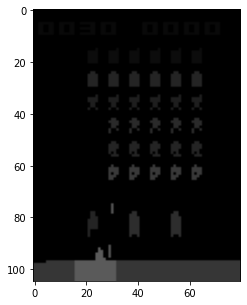

In [971]:
fig = plt.figure(figsize=(5,5))
plt.imshow(States[239])

In [972]:
States.dtype

dtype('uint8')

In [43]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (width,height))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [996]:
make_video(States,name="test2",width=80,height=105,channel=3,fps=30)

In [44]:
make_video(np.array(custom.state_list),name="test3")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

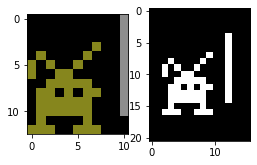

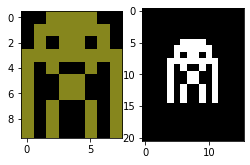

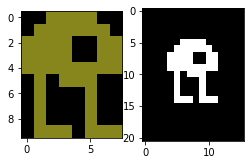

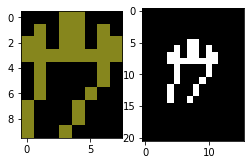

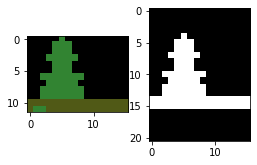

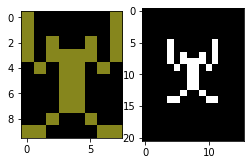

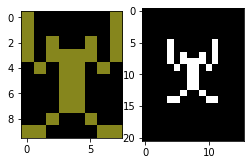

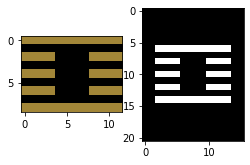

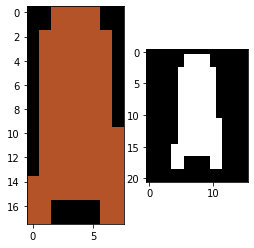

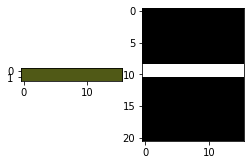

In [27]:
i=0
for k in range(i*10,(i+1)*10):
    fig = plt.figure(figsize=(4,4))
    fig.add_subplot(1,2,1)
    plt.imshow(custom.example_objects[k])
    fig.add_subplot(1,2,2)
    plt.imshow(custom.example_objects_pca[k])

In [29]:
centers=custom.pca_obj.inverse_transform(custom.image_seg.subcluster_centers_).reshape(custom.image_seg.subcluster_centers_.shape[0],210//10,160//10,3)

In [30]:
centers.shape

(255, 21, 16, 3)

In [31]:
np.sum(custom.pca_obj.explained_variance_ratio_[0:40])

0.9995413921551898

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

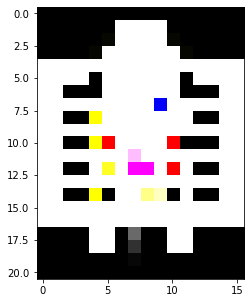

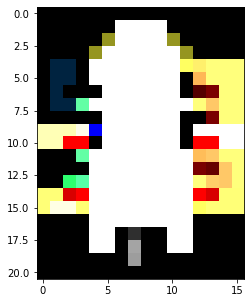

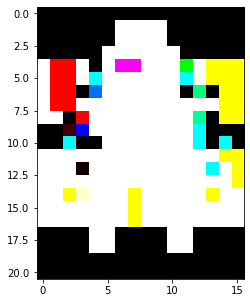

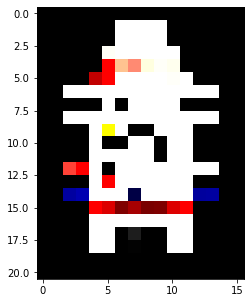

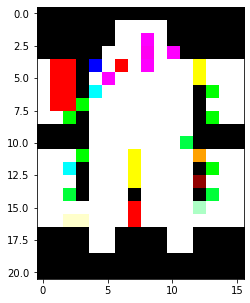

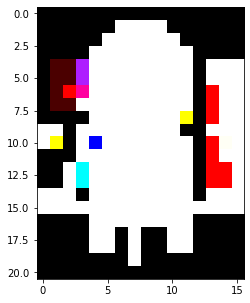

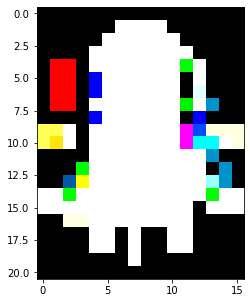

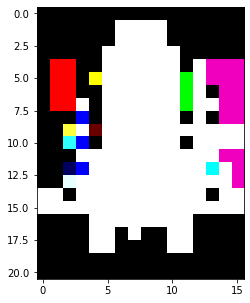

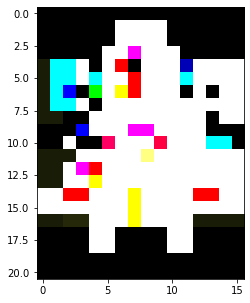

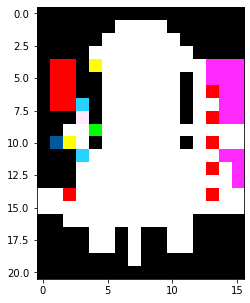

In [32]:
for k in range(i*10,(i+1)*10):
    fig = plt.figure(figsize=(5,5))
    plt.imshow(centers[k])

In [33]:
#%tensorboard --logdir summaries/summary-20220410-201536

# Dimension Reduction

In [173]:
make_video(States,name="test2")

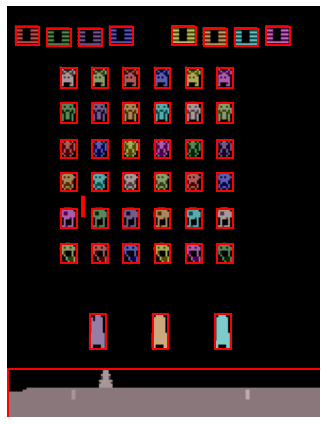

In [25]:
image=States[89]

def find_objects(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(3))

    # label image regions
    label_image = label(reg)
    
    return label_image

label_image=find_objects(image)
visualize_objects(label_image,image)

# Clustering

In [186]:
k=35

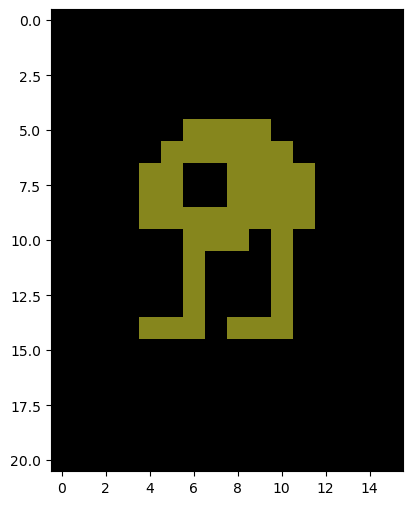

In [187]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(objects[k])

/tmp/ipykernel_5276/296060981.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(size, size,i)


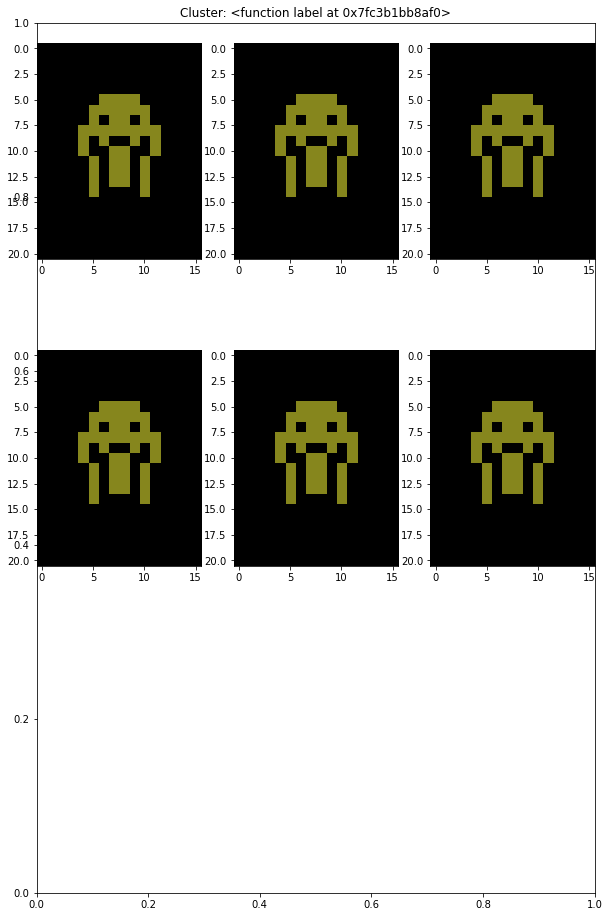

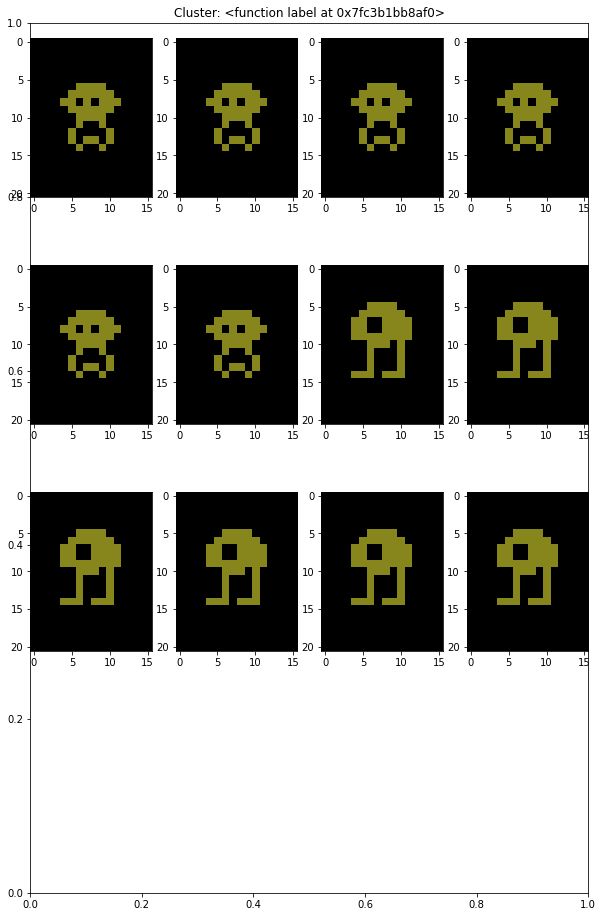

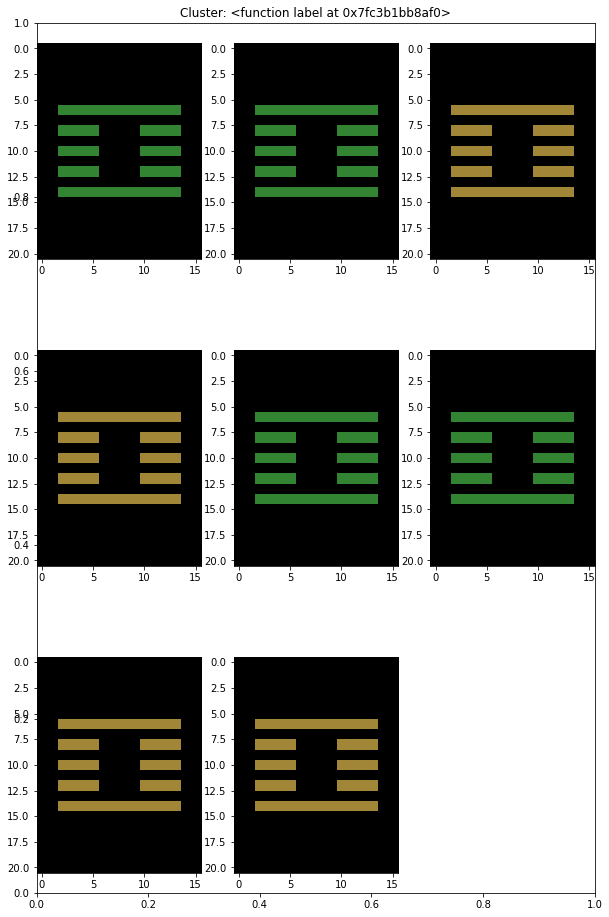

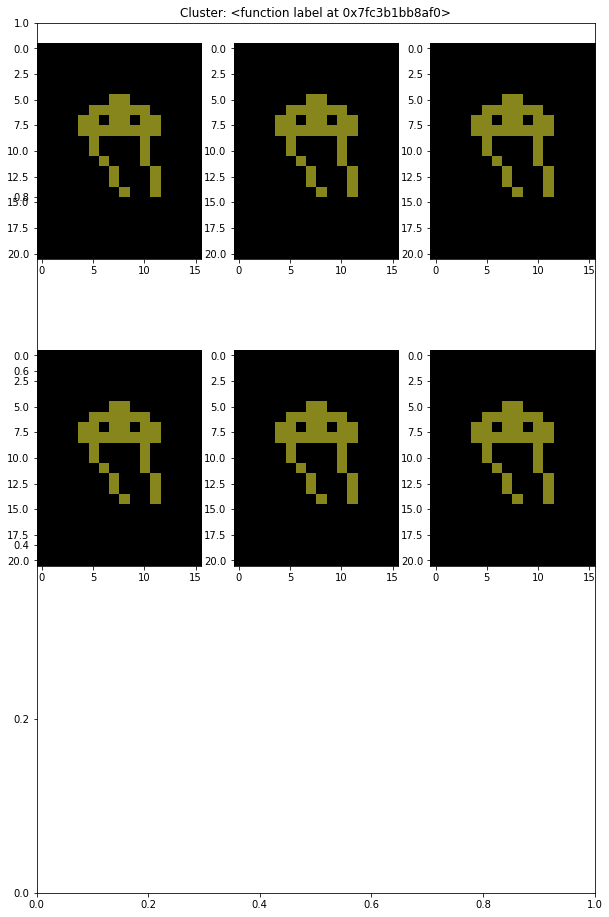

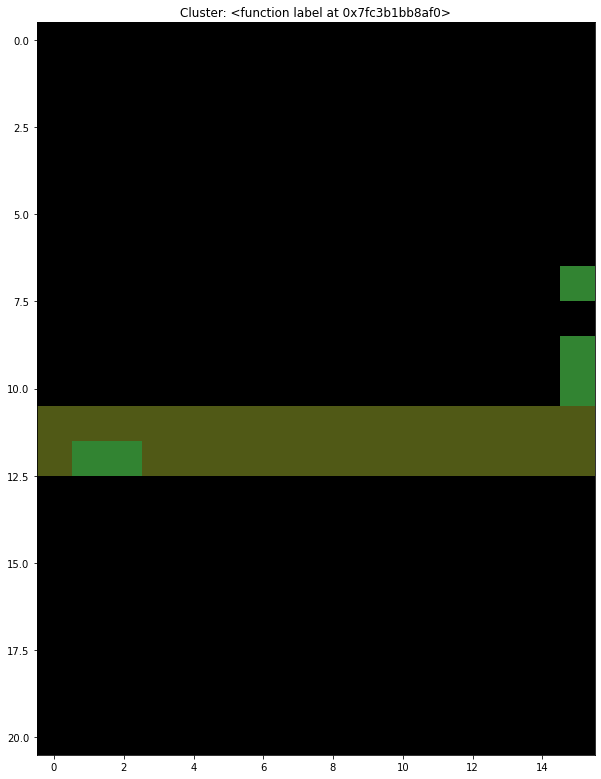

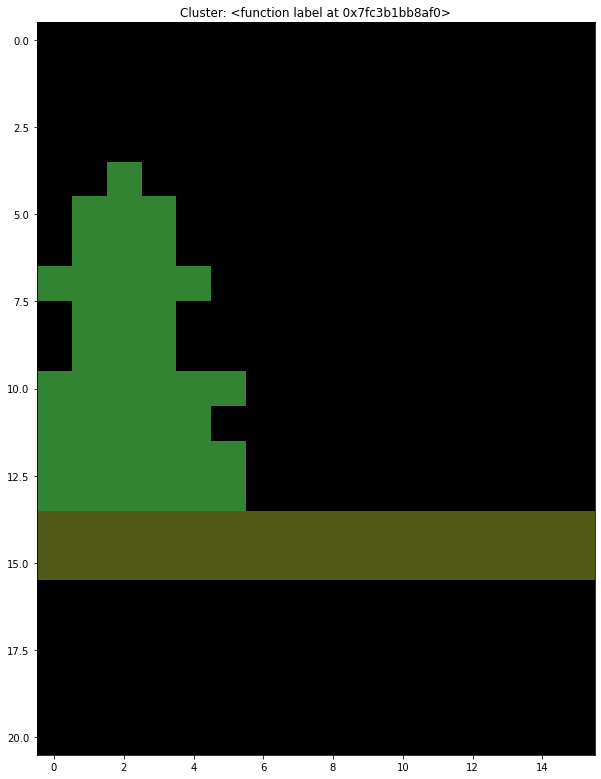

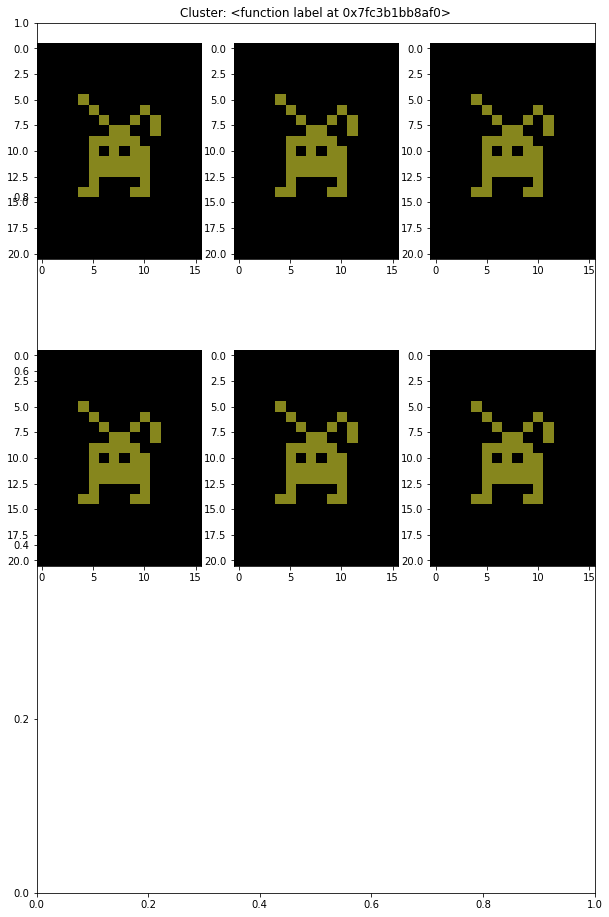

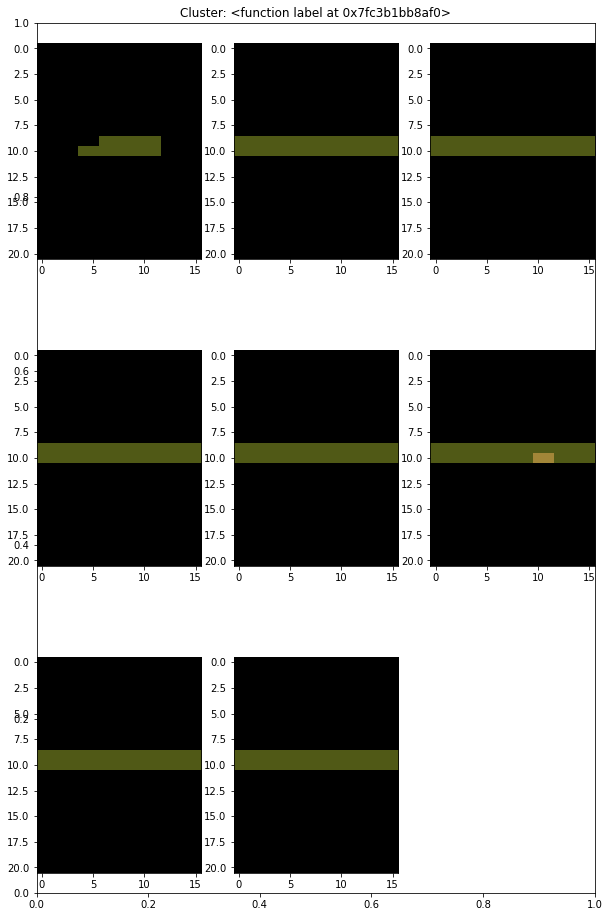

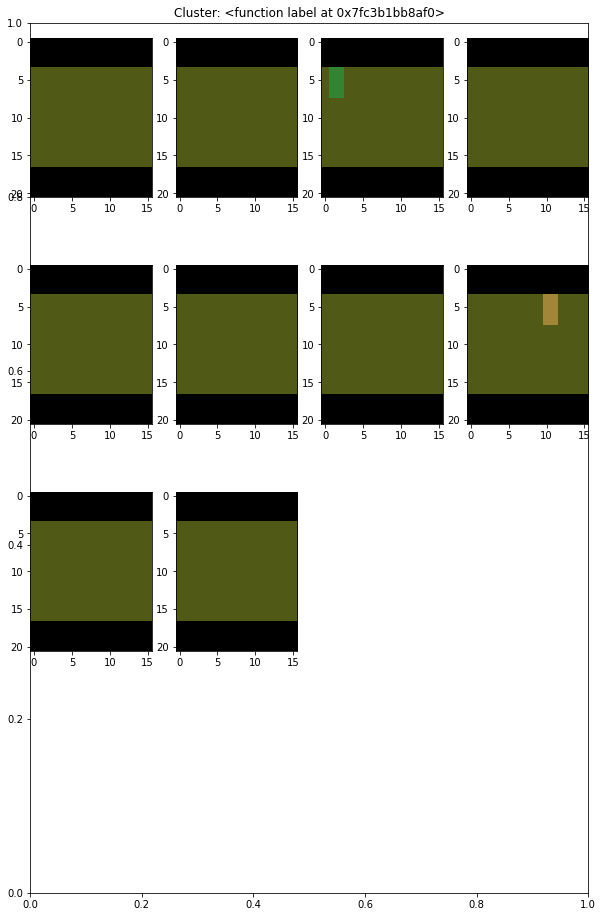

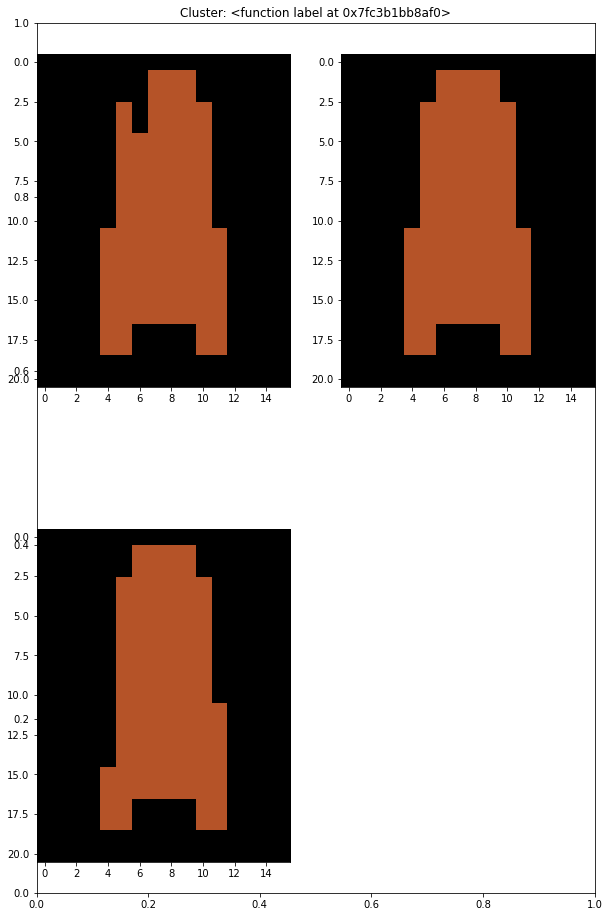

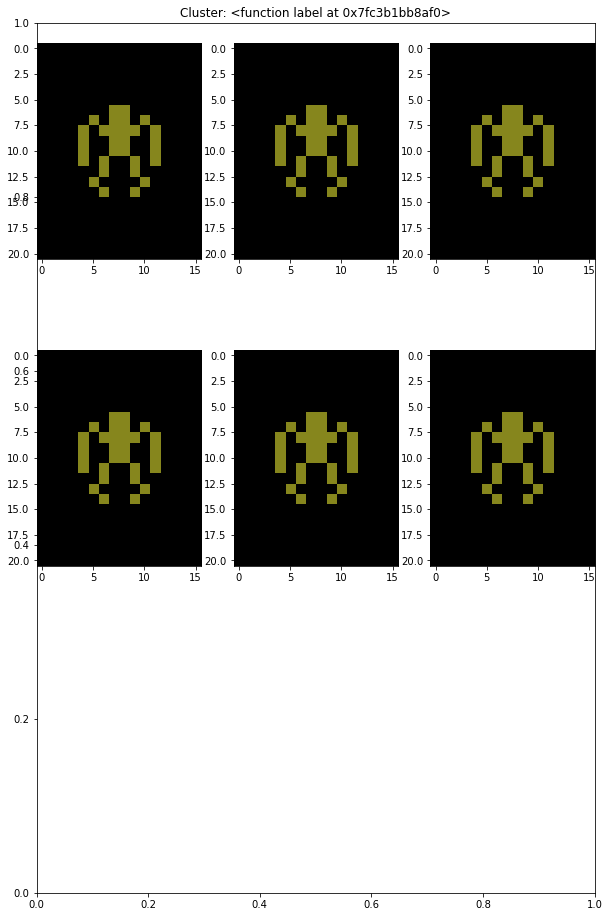

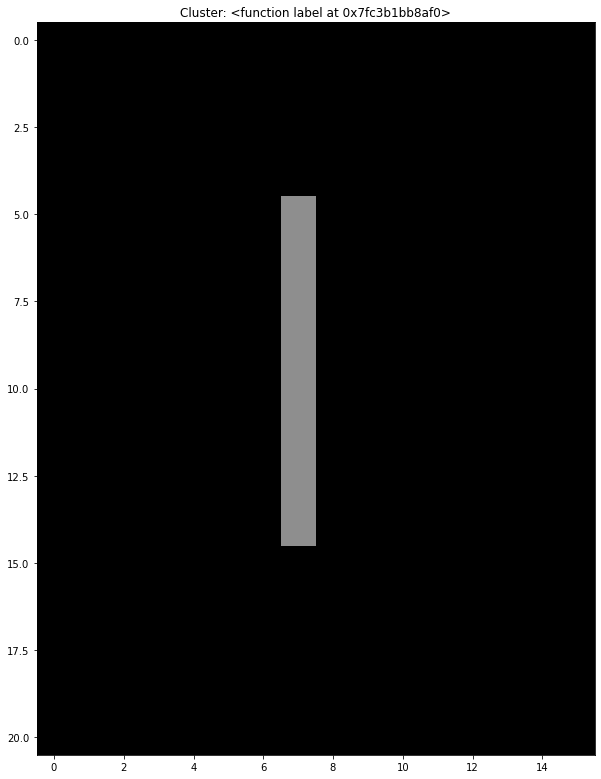

In [43]:
for l in np.unique(lab):
    fig = plt.figure(figsize=(10,16))
    plt.title("Cluster: "+str(label))
    i=1
    size=int(np.ceil(np.sqrt(sum(lab==l))))
    for ob in objects[(lab==l)]:
        fig.add_subplot(size, size,i)
        plt.imshow(ob)
        i+=1

# States Clustering

In [23]:
%time custom.preprocess_state(States[0], train=True, rebuild_vocab=True, train_semantic=True)

CPU times: user 314 ms, sys: 931 ms, total: 1.24 s
Wall time: 192 ms


(array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [13, 13, 13, ..., 13, 13, 13],
        [13, 13, 13, ..., 13, 13, 13],
        [13, 13, 13, ..., 13, 13, 13]], dtype=int8),
 array([ 0,  0,  1,  1,  0,  0,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,
         6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9, 10, 10, 10,
        10, 11, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]),
 array([ 2.2023232e-03,  1.1185906e-03, -1.4057003e-03,  8.6695311e-04,
        -1.1499235e-03,  1.8883420e-03, -3.6855913e-03, -1.3136163e-03,
        -4.6427920e-04,  5.0273538e-04, -4.6745772e-04,  3.0719403e-03,
        -3.8655545e-03, -1.6297543e-03,  2.8408540e-03,  2.0829090e-03,
         3.9068502e-03, -1.9001213e-03, -7.2340932e-05, -1.9848421e-03,
         3.8429000e-04, -3.4775727e-03, -1.4045137e-03, -1.9574889e-03,
     

In [24]:
Graphs=[]
for state in States:
    _,regions,labels,_,_=custom.preprocess_state(state, train=False)
    Graphs.append(regions_to_graph(regions,labels,prox=40))

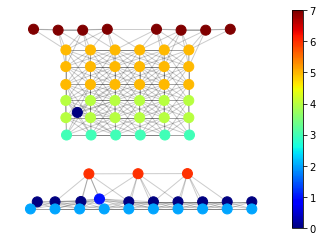

In [25]:
visualize_graph(Graphs[89])

# Emmbedding

In [39]:
dimensions=128
min_count=5
seed=42
workers = 4
epochs = 40
learning_rate = 0.025
min_count = 5
window=5
hs=1
dm=1
negative=0

In [40]:
model = Doc2Vec(
            vector_size=dimensions,
            window=window,
            min_count=min_count,
            dm=dm,
            hs=hs,
            negative=negative,
            workers=workers,
            epochs=epochs,
            alpha=learning_rate,
            seed=seed
        )

In [41]:
%time X=graph_to_embedding(Graphs[0:1],model,iterations=1,epochs=2,keep_train=True,rebuild_vocab=True)

CPU times: user 4.78 ms, sys: 1.56 ms, total: 6.34 ms
Wall time: 5.05 ms


# debug this kernel died

In [42]:
%time X=graph_to_embedding(Graphs[0:2],custom.semantic_model,iterations=1,epochs=2,keep_train=True,rebuild_vocab=True)

CPU times: user 349 ms, sys: 4.85 ms, total: 353 ms
Wall time: 355 ms


In [43]:
%time X=graph_to_embedding(Graphs[0:1],model,iterations=1,epochs=2,keep_train=False)

CPU times: user 558 µs, sys: 1.12 ms, total: 1.67 ms
Wall time: 1.37 ms


In [45]:
%time X=graph_to_embedding(Graphs[0:10],custom.semantic_model,iterations=1,epochs=2,keep_train=True)

CPU times: user 16.4 ms, sys: 876 µs, total: 17.3 ms
Wall time: 15.3 ms


In [26]:
len(custom.semantic_model.wv)

11624

In [56]:
%%time
print(23)

23
CPU times: user 348 µs, sys: 344 µs, total: 692 µs
Wall time: 499 µs


In [27]:
%%time
Doc_all=[]
for i in range(len(Graphs)):
    hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=1, node_attr="feature")
    Doc=[]
    for node in Graphs[i].nodes:
        Doc=Doc+[Graphs[i].nodes[node]["feature"]]+hashes[node]

    Doc_all=Doc_all+[Doc.copy()]
documents = [
        TaggedDocument(words=doc, tags=[])
        for i, doc in enumerate(Doc_all)
    ]

CPU times: user 332 ms, sys: 3.12 ms, total: 335 ms
Wall time: 333 ms


In [ ]:
%%time
if len(model.wv)>0:
    custom.semantic_model.build_vocab(documents,update=True)
else:
    custom.semantic_model.build_vocab(documents)

if True:
    custom.semantic_model.train(documents,total_examples=len(documents),epochs=epochs)

In [72]:
%%time
if len(model.wv)>0:
    model.build_vocab(documents,update=True)
else:
    model.build_vocab(documents)

if True:
    model.train(documents,total_examples=len(documents),epochs=epochs)

CPU times: user 75 ms, sys: 18.9 ms, total: 94 ms
Wall time: 82.3 ms


In [73]:
%%time
#np.array([model.docvecs[str(i)] for i, _ in enumerate(Doc_all)])
model.random.seed(seed)
np.array([model.infer_vector(doc) for doc in Doc_all])

CPU times: user 8.75 ms, sys: 720 µs, total: 9.47 ms
Wall time: 7.42 ms


array([[-0.15001681,  0.281927  , -0.05768201,  0.01878449, -0.15328316,
        -0.6044238 ,  0.29733512, -0.04493698, -0.09675624,  0.18000135,
        -0.07515702, -0.69712585,  0.32217672, -0.16840255, -0.69119287,
        -0.86831903, -0.4675966 ,  0.55028296, -0.12649094, -0.00458426,
         0.22675744, -0.1980129 ,  0.08491789,  0.07900801, -0.05719908,
         0.04654231,  0.0764434 , -0.54959375, -0.27167058,  0.29395568,
         0.11716151,  0.05456242,  0.6470151 ,  0.5474268 , -0.08443402,
        -0.2896211 , -0.1826277 ,  0.07969779,  0.0228097 , -0.28601462,
        -0.4401943 , -0.1549167 ,  0.4138622 , -0.17755896,  0.27861086,
        -0.28721932,  0.47354895,  0.2873887 , -0.39144686, -0.0883512 ,
        -0.02613593,  0.2872235 ,  0.0387474 ,  0.66295975, -0.73578995,
         0.6838928 , -0.28475243,  0.3620826 ,  0.02876975, -0.15288694,
        -0.7099412 ,  0.11088687,  0.7458575 ,  0.16832694, -0.00599143,
        -0.33781192, -0.00527837, -0.37852818,  0.1

In [351]:
X1=graph_to_embedding(Graphs,model,iterations=2,epochs=10,keep_train=False)
X2=graph_to_embedding(Graphs,model,iterations=2,epochs=10,keep_train=False)
np.max((X1-X2)/X1)

-0.0

In [52]:
len(model.wv)

563

In [ ]:
get_normed_vectors()

In [300]:
length, path = nx.single_source_dijkstra(G, 0,weight="weight")

path = dict(nx.all_pairs_dijkstra_path(G,weight="weight",cutoff=70))

nodes_near=[x for x in path[0]][1:5]

a=[G.nodes[x]["position_x"] for x in nodes_near]

b=[G.nodes[x]["position_y"] for x in nodes_near]

ind = np.lexsort((b,a))

np.array(a)[ind]

np.array(b)[ind]

array([], dtype=float64)

In [28]:
X=graph_to_embedding(Graphs,custom.semantic_model,iterations=2,epochs=2,keep_train=False)

In [36]:
brc = Birch(n_clusters=14,threshold=0.015).fit(X)

In [37]:
lab=brc.labels_

In [38]:
np.unique(lab)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

<AxesSubplot:xlabel='x', ylabel='y'>

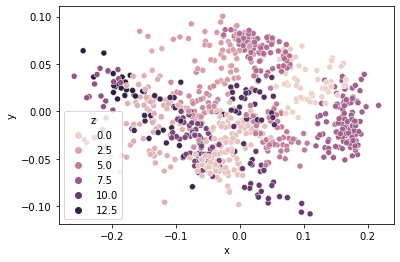

In [39]:
pca = IncrementalPCA(n_components=50)

pca.partial_fit(X)

X = pca.transform(X)

#visualize
df = pd.DataFrame(np.concatenate((X[:,:2],lab.reshape(-1,1)),axis=-1), columns=["x", "y","z"])
sns.scatterplot(data=df,x="x",y="y",hue="z")

In [40]:
np.sum(pca.explained_variance_ratio_[0:2])

0.8798395750368105

In [35]:
np.sum(pca.explained_variance_ratio_[0:40])

0.9812368

In [43]:
np.unique(lab).shape

(14,)

In [44]:
Rewards=trace["reward"]

changes=np.where(lab[1:]!=lab[:-1])[0]

changes=np.concatenate(([0],changes,[len(Rewards)-1]))

In [45]:
changes.shape

(255,)

In [46]:
G=nx.DiGraph()

In [47]:
for c in range(1,len(changes)-1):
    G.add_edge(lab[changes[c]],lab[changes[c+1]], weight=-np.mean(Rewards[changes[c-1]:changes[c]])+100)

G.add_edge(lab[changes[c+1]],-1, weight=-np.mean(Rewards[changes[c]:changes[c+1]])+100)

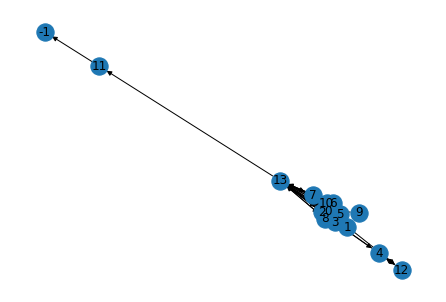

In [48]:
nx.draw(G,with_labels=True)

In [798]:
nx.shortest_path(G, source=0, target=-1, weight="weight", method='dijkstra')

[0, 1, 2, 3, 5, 19, 25, 27, -1]

In [38]:
make_video(States[changes],"test2",fps=7)

# PCA whole images

In [362]:
States_pre=[]
for state in States:
    state,_,_=custom.preprocess_state(state, train=False)
    States_pre.append(state)

In [366]:
States_pre2=np.array(States_pre)

In [369]:
States_pre2=(States_pre2>0)*1

In [372]:
States_pre2=States_pre2.reshape(States_pre2.shape[0],-1)

In [376]:
pca = IncrementalPCA(n_components=128)

pca.partial_fit(States_pre2)

X = pca.transform(States_pre2)

In [378]:
np.sum(pca.explained_variance_ratio_[0:40])

0.9662357233245064

In [383]:
xd=pca.inverse_transform(X[0]).reshape(105,80)>0

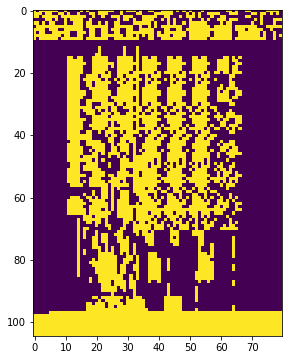

In [385]:
show_image(xd)

# Trees

In [428]:
X=obj_mask

In [429]:
p_h=3
p_w=3
split_h=np.arange(p_h,105-p_h,2).astype("int")
split_w=np.arange(p_w,80-p_w,2).astype("int")

In [430]:
X2=np.zeros((episode_len,len(split_h)*len(split_w),2*p_h+1,2*p_w+1)).astype("int")

In [431]:
position=np.zeros((episode_len,len(split_h)*len(split_w),2))

In [432]:
action=np.zeros((episode_len,len(split_h)*len(split_w),1))

In [433]:
reward=np.zeros((episode_len,len(split_h)*len(split_w),1))

In [434]:
# for i in range(100):
#     j=0
#     for x in range(p_h-1):
#         for y in range(p_w-1):
#             X2[i,j,:,:]=X[i:i+1,split_h[x]:split_h[x+2],split_w[y]:split_w[y+2]]
#             j+=1

In [435]:
for i in range(episode_len):
    j=0
    for x in split_h:
        for y in split_w:
            X2[i,j,:,:]=X[i:i+1,x-p_h:x+p_h+1,y-p_w:y+p_w+1]
            position[i,j,0]=x
            position[i,j,1]=y
            action[i,j,0]=Actions[i]
            reward[i,j,0]=Rewards[i]
            j+=1

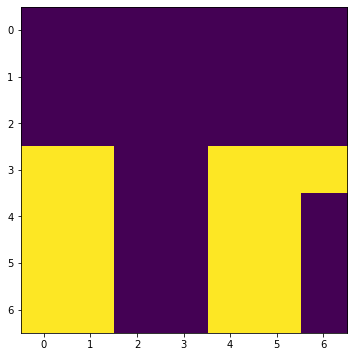

In [436]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(X2[6,68])

In [437]:
X2_prev=X2[0:-2]

X2_now=X2[1:-1]

X2_next=X2[2:]

In [438]:
X2_prev=X2_prev.reshape(-1,2*p_h+1,2*p_w+1).reshape(len(split_h)*len(split_w)*(episode_len-2),-1)

In [439]:
X2_now=X2_prev.reshape(-1,2*p_h+1,2*p_w+1).reshape(len(split_h)*len(split_w)*(episode_len-2),-1)

In [440]:
X2_next=X2_next.reshape(-1,2*p_h+1,2*p_w+1)[:,p_h:p_h+1,p_w:p_w+1].reshape(len(split_h)*len(split_w)*(episode_len-2),)

In [441]:
position_prev=position[0:-2]

position_now=position[1:-1]

position_prev=position_prev.reshape(-1,2)

position_now=position_now.reshape(-1,2)

In [442]:
action_prev=action[0:-2]

action_now=action[1:-1]

action_prev=action_prev.reshape(-1,1)

action_now=action_now.reshape(-1,1)

In [443]:
reward_prev=reward[0:-2]

reward_now=reward[1:-1]

reward_prev=reward_prev.reshape(-1,1)

reward_now=reward_now.reshape(-1,1)

In [444]:
#prev_state positionx positiony action time reward?

In [445]:
nominal_attributes=np.arange(2*X2_prev.shape[1]+2).astype("int")

In [446]:
nominal_attributes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [447]:
state=np.hstack((action_prev,action_now,X2_prev,X2_now,position_now,reward_prev,reward_now))

In [448]:
state.shape

(1467050, 104)

In [394]:
lc_ht = VeryFastDecisionRulesClassifier(nominal_attributes=nominal_attributes)

In [395]:
%time lc_ht.partial_fit(state,X2_next)

CPU times: user 9min 43s, sys: 691 ms, total: 9min 44s
Wall time: 9min 49s


VeryFastDecisionRulesClassifier(drift_detector=None, expand_confidence=1e-07,
                                expand_criterion='info_gain', grace_period=200,
                                max_rules=1000, min_weight=100,
                                nb_prediction=True, nb_threshold=0,
                                nominal_attributes=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                ordered_rules=True, remove_poor_atts=False,
                                rule_prediction='first_hit',
                                tie_threshold=0.05)

In [381]:
# lc_ht = HoeffdingTreeClassifier(nominal_attributes=nominal_attributes)

In [382]:
# %time lc_ht.partial_fit(state[::1000],X2_next[::1000])

CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.58 s


HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                        leaf_prediction='nba', max_byte_size=33554432,
                        memory_estimate_period=1000000, nb_threshold=0,
                        no_preprune=False,
                        nominal_attributes=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                        remove_poor_atts=False, split_confidence=1e-07,
                        split_criterion='info_gain', stop_mem_management=False,
                        tie_threshold=0.05)

In [390]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32)
])

In [391]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [393]:
%time model.fit(state[::1000],X2_next[::1000], epochs=10)

Epoch 1/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2860 - accuracy: 0.9292
Epoch 2/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9469
Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.9564
Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1130 - accuracy: 0.9680
Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1088 - accuracy: 0.9619
Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0869 - accuracy: 0.9707
Epoch 7/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1051 - accuracy: 0.9707
Epoch 8/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9796
Epoch 9/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.9775
Epoch 10/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.9809
CPU times: user 1.0

In [397]:
%time Y=lc_ht.predict(state[::1000])

CPU times: user 1.94 s, sys: 4.07 ms, total: 1.94 s
Wall time: 1.94 s


/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/skmultiflow/rules/very_fast_decision_rules.py:837: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(predictions)


In [ ]:
Y

In [ ]:
Y2=X2_next

In [ ]:
np.mean(Y2==Y)

In [ ]:
for x in np.unique(Y2):
    print(str(x)+":"+str(np.mean(Y2[Y2==x]==Y[Y2==x]))+" N:"+str(np.sum(Y2==x)))

In [398]:
print(lc_ht.get_model_description())

Rule 0 :Att (75) = 0.000 and Att (99) = 0.000 and Att (100) <= 84.820 and Att (73) = 17.000| class :0  {0: 9866.0, 10: 2.0, 17: 171.0, 25: 2.0, 31: 1.0}
Rule 1 :Att (75) = 0.000 and Att (67) = 0.000 and Att (69) = 0.000 and Att (101) <= 9.550 and Att (100) <= 11.550 and Att (1) != 5.000| class :0  {0: 3035.0, 8: 8.0}
Rule 2 :Att (100) <= 39.910 and Att (75) = 0.000 and Att (74) = 2.000| class :0  {0: 5585.0, 2: 172.0, 5: 1.0}
Rule 3 :Att (75) = 0.000 and Att (76) = 0.000 and Att (66) = 0.000 and Att (101) <= 16.820 and Att (100) <= 11.360 and Att (0) != 0.000| class :0  {0: 2413.0, 8: 2.0}
Rule 4 :Att (75) = 0.000 and Att (66) = 0.000 and Att (68) != 0.000| class :0  {0: 18615.0, 2: 23.0, 5: 399.0, 8: 6.0, 9: 273.0, 10: 24.0, 14: 1.0, 16: 1.0, 17: 185.0, 18: 1.0, 20: 1.0, 23: 4.0, 25: 261.0, 29: 54.0}
Rule 5 :Att (100) <= 7.910 and Att (75) = 0.000 and Att (67) = 0.000 and Att (101) <= 15.000| class :0  {0: 1359.4968314802538, 8: 2.0}
Rule 6 :Att (75) = 0.000 and Att (82) = 0.000 and A

In [399]:
print(lc_ht.get_rules_description())

AttributeError: 'VeryFastDecisionRulesClassifier' object has no attribute 'get_rules_description'

In [400]:
len(lc_ht.get_model_rules())

21

In [401]:
print(lc_ht.get_model_description())

Rule 0 :Att (75) = 0.000 and Att (99) = 0.000 and Att (100) <= 84.820 and Att (73) = 17.000 | class: 0| class :0  {0: 9866.0, 10: 2.0, 17: 171.0, 25: 2.0, 31: 1.0}
Rule 1 :Att (75) = 0.000 and Att (67) = 0.000 and Att (69) = 0.000 and Att (101) <= 9.550 and Att (100) <= 11.550 and Att (1) != 5.000 | class: 0| class :0  {0: 3035.0, 8: 8.0}
Rule 2 :Att (100) <= 39.910 and Att (75) = 0.000 and Att (74) = 2.000 | class: 0| class :0  {0: 5585.0, 2: 172.0, 5: 1.0}
Rule 3 :Att (75) = 0.000 and Att (76) = 0.000 and Att (66) = 0.000 and Att (101) <= 16.820 and Att (100) <= 11.360 and Att (0) != 0.000 | class: 0| class :0  {0: 2413.0, 8: 2.0}
Rule 4 :Att (75) = 0.000 and Att (66) = 0.000 and Att (68) != 0.000 | class: 0| class :0  {0: 18615.0, 2: 23.0, 5: 399.0, 8: 6.0, 9: 273.0, 10: 24.0, 14: 1.0, 16: 1.0, 17: 185.0, 18: 1.0, 20: 1.0, 23: 4.0, 25: 261.0, 29: 54.0}
Rule 5 :Att (100) <= 7.910 and Att (75) = 0.000 and Att (67) = 0.000 and Att (101) <= 15.000 | class: 0| class :0  {0: 1359.49683148

In [402]:
r=lc_ht.get_model_rules()[2]

In [403]:
r.predicate_set

[Predicate(att_idx=100, operator='<=', value=39.90909090909091),
 Predicate(att_idx=75, operator='=', value=0.0),
 Predicate(att_idx=74, operator='=', value=2.0)]

In [467]:
p_h=3
p_w=3
split_h=np.arange(p_h,105-p_h,1).astype("int")
split_w=np.arange(p_w,80-p_w,1).astype("int")

In [468]:
split_w

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76])

In [469]:
k=500

In [470]:
obj_mask[0]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [19, 19, 19, ..., 19, 19, 19],
       [19, 19, 19, ..., 19, 19, 19],
       [19, 19, 19, ..., 19, 19, 19]], dtype=int8)

In [471]:
X2_prev=obj_mask[k:k+1][0]

X2_now=obj_mask[k+1:k+2][0]

X2_next=obj_mask[k+2:k+3][0]

action_prev=Actions[k:k+1][0]

action_now=Actions[k+1:k+2][0]

reward_prev=Rewards[k:k+1][0]

reward_now=Rewards[k+1:k+2][0]

In [472]:
X2_prev.shape

(105, 80)

In [473]:
Y=X2_now.copy()

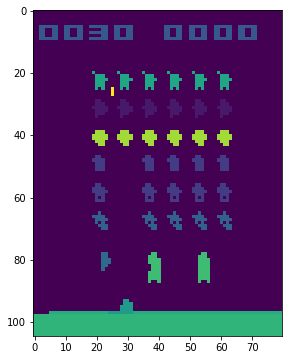

In [474]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(X2_now)

In [475]:
state.shape

(90,)

In [476]:
x

3

In [477]:
y

77

In [478]:
for x in split_h:
    for y in split_w:
        state=np.hstack((action_prev,action_now,X2_prev[x-p_h:x+p_h+1,y-p_w:y+p_w+1].reshape(-1),X2_now[x-p_h:x+p_h+1,y-p_w:y+p_w+1].reshape(-1),np.array([x,y]),reward_prev,reward_now))
        Y[x-p_h:x+p_h+1,y-p_w:y+p_w+1]=lc_ht.predict(state.reshape(1,-1))

In [479]:
np.mean(Y[X2_next!=0]==X2_next[X2_next!=0])

0.45925925925925926

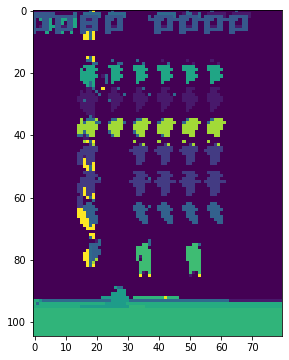

In [480]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(Y)

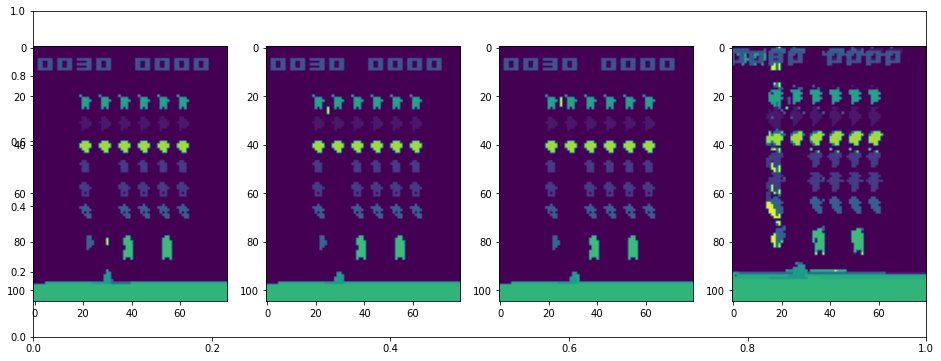

In [481]:
fig, ax = plt.subplots(figsize=(16, 6))
fig.add_subplot(1,4,1)
plt.imshow(X2_prev)
fig.add_subplot(1,4,2)
plt.imshow(X2_now)
fig.add_subplot(1,4,3)
plt.imshow(X2_next)
fig.add_subplot(1,4,4)
plt.imshow(Y)

# Ontology

In [396]:
onto = owl.get_ontology("http://test.org/onto.owl")

In [84]:
onto

get_ontology("http://test.org/onto.owl#")

In [436]:
class State(owl.Thing):
    namespace = onto

In [437]:
class Action(owl.Thing):
    namespace = onto

In [438]:
class from_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [State]
    range  = [Action]

In [439]:
class to_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [Action]
    range  = [State]

In [445]:
with onto:
    class object_representant(owl.DataProperty):
        domain = [Object]
        range = [str]

In [449]:
with onto:
    class object_position_x(owl.DataProperty):
        domain = [Object]
        range = [int]

In [450]:
with onto:
    class object_position_y(owl.DataProperty):
        domain = [Object]
        range = [int]

In [446]:
class Object(owl.Thing):
    namespace = onto

In [460]:
regions[0].bbox

(10, 4, 19, 16)

In [464]:
kmeans.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       0, 0, 0], dtype=int32)

In [466]:
my_object = Object("my_object", namespace = onto, object_representant = ["rep"],object_position_x=[0],object_position_y=[0])

In [467]:
onto.my_object.get_properties()

{einsteins_riddle.object_representant,
 einsteins_riddle.object_position_x,
 einsteins_riddle.object_position_y}

# Reasoning

In [418]:
onto = owl.get_ontology("file://einsteins_riddle.rdf").load()

# Grounding

In [419]:
onto.name

'einsteins_riddle'

In [420]:
list(onto.classes())

[owl.Nothing,
 einsteins_riddle.owl.Beverage,
 einsteins_riddle.owl.Man,
 einsteins_riddle.owl.Color,
 einsteins_riddle.owl.House,
 einsteins_riddle.owl.Pet,
 einsteins_riddle.owl.Cigarette]

In [421]:
list(onto.individuals())

[einsteins_riddle.owl.orange_juice,
 einsteins_riddle.owl.tea,
 einsteins_riddle.owl.water,
 einsteins_riddle.owl.coffee,
 einsteins_riddle.owl.milk,
 einsteins_riddle.owl.Kools,
 einsteins_riddle.owl.Lucky_Strike,
 einsteins_riddle.owl.Parliaments,
 einsteins_riddle.owl.Chesterfields,
 einsteins_riddle.owl.Old_Gold,
 einsteins_riddle.owl.green,
 einsteins_riddle.owl.red,
 einsteins_riddle.owl.blue,
 einsteins_riddle.owl.yellow,
 einsteins_riddle.owl.ivory,
 einsteins_riddle.owl.house-2,
 einsteins_riddle.owl.house-3,
 einsteins_riddle.owl.house-1,
 einsteins_riddle.owl.house-4,
 einsteins_riddle.owl.house-5,
 einsteins_riddle.owl.Ukrainian,
 einsteins_riddle.owl.Spaniard,
 einsteins_riddle.owl.Norwegian,
 einsteins_riddle.owl.Englishman,
 einsteins_riddle.owl.Japanese,
 einsteins_riddle.owl.zebra,
 einsteins_riddle.owl.horse,
 einsteins_riddle.owl.snails,
 einsteins_riddle.owl.dog,
 einsteins_riddle.owl.fox]

In [422]:
list(onto.properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes,
 1.1.description,
 1.1.date,
 1.1.creator]

In [423]:
list(onto.object_properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes]

In [424]:
list(onto.disjoints())

[AllDisjoint([einsteins_riddle.owl.Chesterfields, einsteins_riddle.owl.Englishman, einsteins_riddle.owl.Japanese, einsteins_riddle.owl.Kools, einsteins_riddle.owl.Lucky_Strike, einsteins_riddle.owl.Norwegian, einsteins_riddle.owl.Old_Gold, einsteins_riddle.owl.Parliaments, einsteins_riddle.owl.Spaniard, einsteins_riddle.owl.Ukrainian, einsteins_riddle.owl.blue, einsteins_riddle.owl.coffee, einsteins_riddle.owl.dog, einsteins_riddle.owl.fox, einsteins_riddle.owl.green, einsteins_riddle.owl.horse, einsteins_riddle.owl.house-1, einsteins_riddle.owl.house-2, einsteins_riddle.owl.house-3, einsteins_riddle.owl.house-4, einsteins_riddle.owl.house-5, einsteins_riddle.owl.ivory, einsteins_riddle.owl.milk, einsteins_riddle.owl.orange_juice, einsteins_riddle.owl.red, einsteins_riddle.owl.snails, einsteins_riddle.owl.tea, einsteins_riddle.owl.water, einsteins_riddle.owl.yellow, einsteins_riddle.owl.zebra], ontology = get_ontology("http://persons.iis.nsk.su/files/persons/pages/einsteins_riddle.owl#

In [426]:
with onto:
    owl.sync_reasoner(infer_property_values = True)

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit:/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpwhqkkfrx -Y


* Owlready * Adding relation einsteins_riddle.owl.Norwegian smokes einsteins_riddle.owl.Kools
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian smokes einsteins_riddle.owl.Chesterfields
* Owlready * Adding relation einsteins_riddle.owl.Spaniard smokes einsteins_riddle.owl.Lucky_Strike
* Owlready * Adding relation einsteins_riddle.owl.Englishman smokes einsteins_riddle.owl.Old_Gold
* Owlready * Adding relation einsteins_riddle.owl.Norwegian owns einsteins_riddle.owl.fox
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian owns einsteins_riddle.owl.horse
* Owlready * Adding relation einsteins_riddle.owl.Englishman owns einsteins_riddle.owl.snails
* Owlready * Adding relation einsteins_riddle.owl.Japanese owns einsteins_riddle.owl.zebra
* Owlready * Adding relation einsteins_riddle.owl.Norwegian drinks einsteins_riddle.owl.water
* Owlready * Adding relation einsteins_riddle.owl.Spaniard drinks einsteins_riddle.owl.orange_juice
* Owlready * Adding relation einsteins_riddle

* Owlready2 * HermiT took 1.7078933715820312 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [427]:
query = owl.default_world.prepare_sparql("""SELECT ?house ?man Where{ ?house a einsteins_riddle:House. ?man a einsteins_riddle:Man. ?man einsteins_riddle:lives_in ?house. 
}""")

In [428]:
list(query.execute())

[[einsteins_riddle.owl.house-2, einsteins_riddle.owl.Ukrainian],
 [einsteins_riddle.owl.house-4, einsteins_riddle.owl.Spaniard],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-3, einsteins_riddle.owl.Englishman],
 [einsteins_riddle.owl.house-5, einsteins_riddle.owl.Japanese]]